## Notebook for retrieving statistical information from histograms and performing mixture modelling

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from scipy.stats import norm
from sklearn.mixture import GaussianMixture as GMM
from scipy import stats
import json

from scipy.stats import beta

In [65]:
def get_dict_from_file(file_name, data_type, window=None, step_sizes=None, restriction=None,
                       batch_number=None,path='h_dict_data/'):
    """
    Reads in dictionary of H values.
    """
    if data_type == 'hurst':
        with open(path+'h_dict_'+'w{}_'.format(window)+'s{}_'.format(max(step_sizes))+'r{}_'.format(restriction)+file_name, 'r') as file:
            dictionary = file.read()
    if data_type == 'cos_theta':
        with open(path+'cos_theta_dict_'+file_name+'_b{}'.format(batch_number), 'r') as file:
            dictionary = file.read()
        

    return json.loads(dictionary)

def optimum_components(data,n_max,plot=0):
    bics = []
    aics = []
    min_bic = 0
    min_aic = 0
    b_counter=1
    a_counter=1
    for i in np.arange(1,n_max-1): # test the AIC/BIC metric between 1 and 10 components
        gmm = GMM(n_components = i, max_iter=1000, random_state=10, covariance_type = 'full')
        labels = gmm.fit(data).predict(data)
        bic = gmm.bic(data)
        aic = gmm.aic(data)
        bics.append(bic)
        aics.append(aic)
        if bic < min_bic or min_bic == 0:
            min_bic = bic
            opt_bic = b_counter
        b_counter +=1
        if aic < min_aic or min_aic == 0:
            min_aic = aic
            opt_aic = a_counter
        a_counter +=1
    
    if plot==1:    
        fig,ax = plt.subplots(figsize=(10, 4))
        # Plot 1
        plt.plot(np.arange(1,n_max-1), bics, 'o-', lw=3, c='black', label='BIC')
        plt.plot(np.arange(1,n_max-1), aics, 'o-', lw=3, label='AIC')
        plt.legend(frameon=False, fontsize=15)
        plt.xlabel('Number of components', fontsize=12)
        plt.ylabel('Bayesian Information criterion', fontsize=12)
        plt.xticks(np.arange(0,n_max, 2))
        plt.title('Opt. components = '+str(opt_bic), fontsize=20)
        plt.show()

        
    return opt_bic,bics,opt_aic,aics

def plot_3d(dictionary, all_step_sizes, n_bins,data_variable="H",absolute=False):
    
    %matplotlib notebook
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection="3d")
    cmap = plt.cm.plasma
    
    steps = [int(s) for s in list(dictionary)]
    yticks = np.array(steps)
    
    norm_counts, bins = get_hist(dictionary,n_bins,absolute=absolute)

    for i,_ in enumerate(steps):
        ytick = yticks[i]
        temp_counts = norm_counts[i]
        temp_bins = bins[i]
        xcenter = np.convolve(temp_bins, np.ones(2), "valid")/2
        xwidth = np.diff(temp_bins)
        ax.bar(left=xcenter, height=temp_counts, width=xwidth, zs=ytick,
               zdir="y", color=cmap(i/len(yticks)), alpha=0.7, edgecolor="grey", linewidth=0.3)

    ax.set_xlabel("{}".format(data_variable))
    ax.set_ylabel("downsampling step size")
    ax.set_zlabel("p({})".format(data_variable))

    ax.set_yticks(yticks)
    plt.show()
    
    return norm_counts, bins

def get_hist(dictionary, nbins,absolute=False):
    """
    """
    keys_list = list(dictionary)
    
    counts_all = np.empty((len(keys_list), nbins))
    bins_all = np.empty((len(keys_list), nbins+1))
    
    if absolute==False:
    
        for i,key in enumerate(keys_list):
            counts, bins = np.histogram(dictionary[key], nbins, density=True)  # normalised so area under histogram is 1
            counts_all[i] = counts
            bins_all[i] = bins
    else:
        
        for i,key in enumerate(keys_list):
            counts, bins = np.histogram([abs(x) for x in dictionary[key]], nbins, density=True)  # normalised so area under histogram is 1
            counts_all[i] = counts
            bins_all[i] = bins

    return counts_all, bins_all

In [66]:
cos_theta_dict = get_dict_from_file('LanB1_frame400-600','cos_theta',batch_number=2,path='haemocyte_cos_theta_data/')

In [67]:
len(cos_theta_dict['8'])

52838

<IPython.core.display.Javascript object>


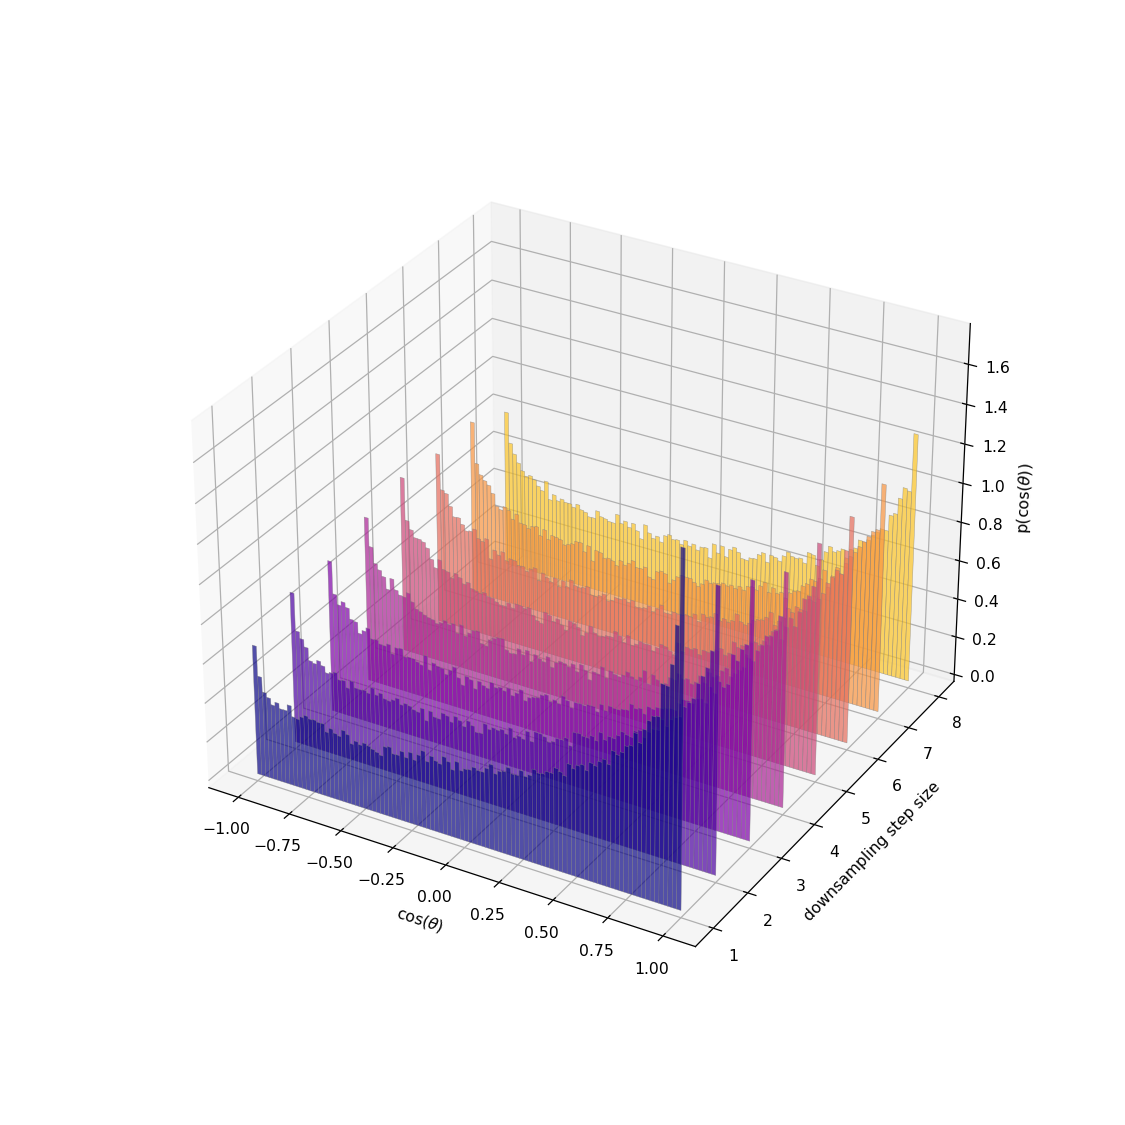

In [69]:
norm_counts, bins = plot_3d(cos_theta_dict,[1,2,3,4,5,6,7,8],100,absolute=False,data_variable="cos({})".format(r'$\theta$'))

In [98]:
def get_hist_mids(bins):
    
    return 0.5*(bins[1:] + bins[:-1])

def get_hist_probs(counts,bins,biased=False):
    
    if biased==False:
        probs = counts / (np.sum(counts)-1)
    else:
        probs = counts/np.sum(counts)
        
    return probs

def get_hist_mean(probs,mids):
    
    return np.sum(mids*probs)

def get_hist_sd(probs,mids,mean):
    
    x_2 = np.sum((mids**2)*probs)
    
    return np.sqrt(x_2 - mean**2)

def get_hist_skew(probs,mids,mean,sd):
    
    return np.sum(((mids-mean)/sd)**3)

def return_stats(counts, bins):
    
    hist_probs = get_hist_probs(counts,bins)
    hist_mids = get_hist_mids(bins)
    hist_mean = get_hist_mean(hist_probs,hist_mids)
    hist_sd = get_hist_sd(hist_probs,hist_mids,hist_mean)
    hist_skew = get_hist_skew(hist_probs,hist_mids,hist_mean,hist_sd)
    
    return hist_mean,hist_sd,hist_skew
    
    

In [99]:
def get_stats_dict(total_counts,total_bins,pandas_df=True):
    stats_dict = {}
    stats_dict['mean'] = np.empty(len(total_counts))
    stats_dict['sd'] = np.empty(len(total_counts))
    stats_dict['skew'] = np.empty(len(total_counts))
    
    for i in np.arange(len(total_counts)):
        mean,sd,skew = return_stats(total_counts[i],total_bins[i])
        stats_dict['mean'][i] = mean
        stats_dict['sd'][i] = sd
        stats_dict['skew'][i] = skew 
        
    if not pandas_df:
        return stats_dict
    
    else:
        column_labels = np.arange(1,len(total_counts)+1)
        df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=column_labels)
        return df.apply(pd.to_numeric, downcast='integer')
        

In [100]:
get_stats_dict(norm_counts,bins)

,1,2,3,4,5,6,7,8
mean,0.197723,0.138399,0.099724,0.075221,0.063499,0.063507,0.077259,0.097298
sd,0.624574,0.629988,0.633375,0.637792,0.640917,0.640933,0.640171,0.636938
skew,-84.317895,-56.406777,-39.634414,-29.154802,-24.213871,-24.215369,-29.620848,-38.005684


### Scrap code

def get_dict_from_file(file_name, window, step_sizes, restriction,
                       path='h_dict_data/',full_file_name=None):
    """
    Reads in dictionary of H values.
    """
    try:
        with open(path+'h_dict_'+'w{}_'.format(window)+'s{}_'.format(max(step_sizes))+'r{}_'.format(restriction)+file_name, 'r') as file:
            h_dict = file.read()
    except FileNotFoundError:
        with open(path+'h_dict_'+'w{}_'.format(window)+'s{}_'.format(max(step_sizes))+'r{}_'.format(restriction)+file_name+'.txt', 'r') as file:
            h_dict = file.read()
        
    return json.loads(h_dict)


<IPython.core.display.Javascript object>


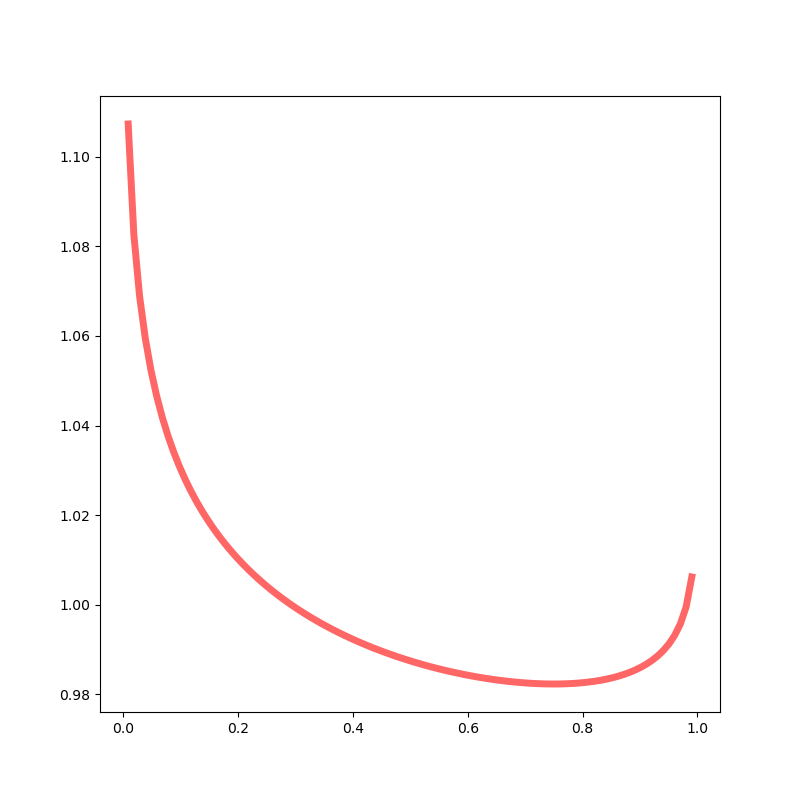

In [97]:
a, b = 0.97,.99
fig,ax = plt.subplots(figsize=(8,8))
x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
ax.plot(x, beta.pdf(x, a, b),
       'r-', lw=5, alpha=0.6, label='beta pdf')